# Bayesian Neural Networks

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')
cluster_candidates['distance'] = 1000./ cluster_candidates['parallax']

scaler_astrometry = StandardScaler()
scaler_rv = StandardScaler()

#cluster_candidates[['ra','dec','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
#cluster_candidates[['radial_velocity']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity']])

del cluster_candidates['Unnamed: 0']

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
#cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) <= \
    0.2*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 1494
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     334 non-null    int64  
 1   index                       334 non-null    int64  
 2   source_id                   334 non-null    int64  
 3   ra                          334 non-null    float64
 4   ra_error                    334 non-null    float64
 5   dec                         334 non-null    float64
 6   dec_error                   334 non-null    float64
 7   l                           334 non-null    float64
 8   b                           334 non-null    float64
 9   parallax                    334 non-null    float64
 10  parallax_error              334 non-null    float64
 11  pmra                        334 non-null    float64
 12  pmra_error                  334 non-null    float64
 13  pmdec                       33

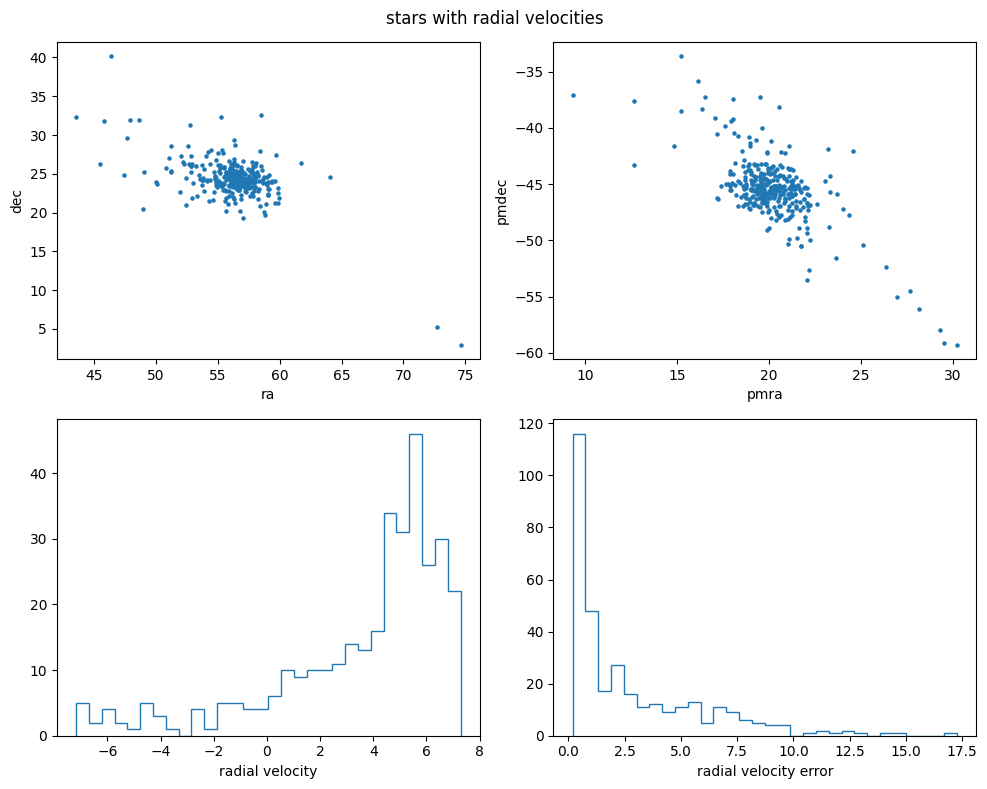

In [3]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('radial velocity error')
fig.tight_layout()
plt.show()

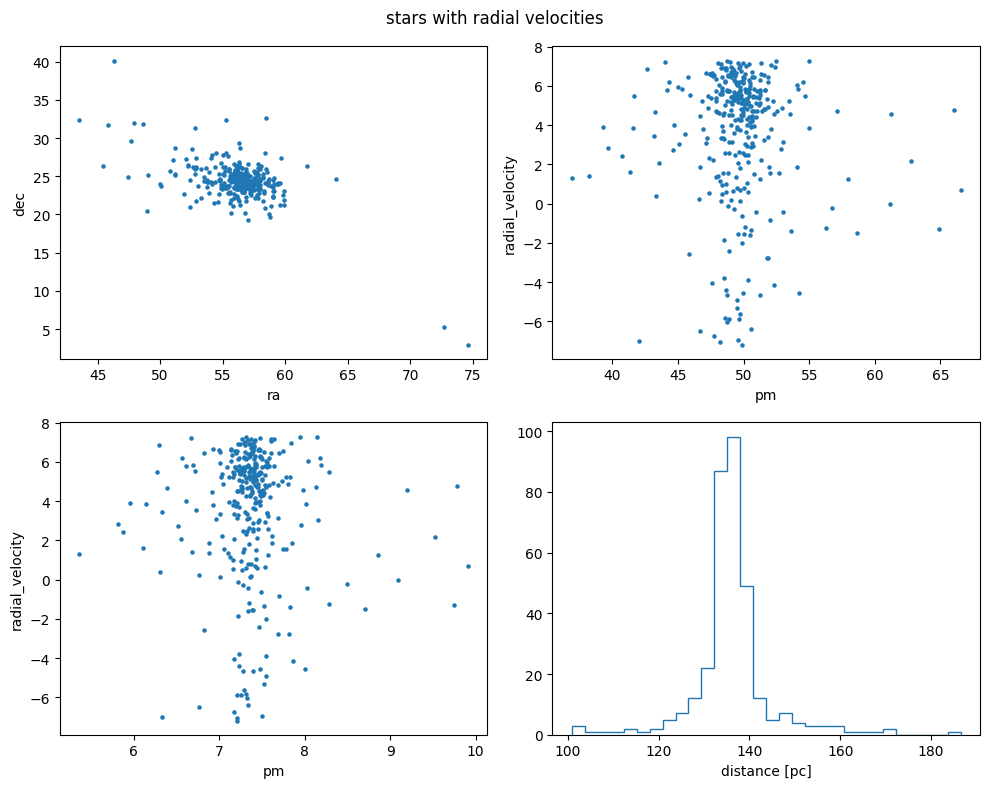

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

pm_total = np.sqrt(cluster_candidates_rv['pmra']**2 + cluster_candidates_rv['pmdec']**2)
ax[0,1].scatter(pm_total, cluster_candidates_rv['radial_velocity'], s=5)
ax[0,1].set_xlabel('pm')
ax[0,1].set_ylabel('radial_velocity')

ax[1,0].scatter(cluster_candidates_rv['parallax'], cluster_candidates_rv['radial_velocity'], s=5)
ax[1,0].set_xlabel('pm')
ax[1,0].set_ylabel('radial_velocity')

ax[1,1].hist(cluster_candidates_rv['distance'], bins=30, density=False, histtype='step')
ax[1,1].set_xlabel('distance [pc]')

fig.tight_layout()
plt.show()

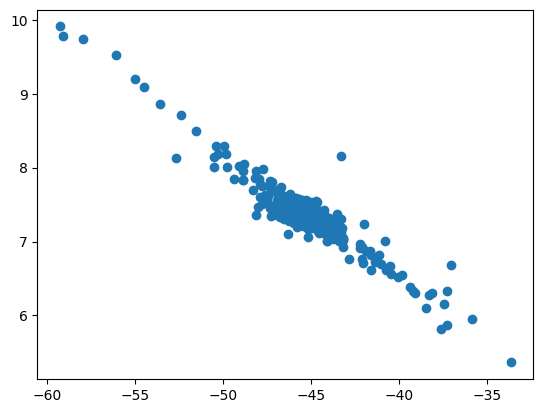

In [5]:
plt.scatter(cluster_candidates_rv['pmdec'], cluster_candidates_rv['parallax'])

In [6]:
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','distance']])
#x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec']])
#x_data = np.array(cluster_candidates_rv[['l','b','pmra','pmdec','parallax']])

#y_data = np.array(cluster_candidates_rv[['radial_velocity','radial_velocity_error']])
y_data = np.array(cluster_candidates_rv[['radial_velocity']])
x_data.shape, y_data.shape

((334, 5), (334, 1))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print('Training shape:', x_train.shape, y_train.shape)
print('Testing shape:', x_test.shape, y_test.shape)

Training shape: (267, 5) (267, 1)
Testing shape: (67, 5) (67, 1)


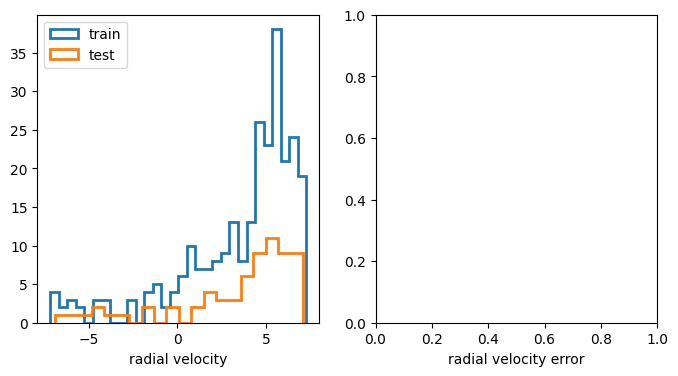

In [8]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(y_train[:,0], bins=30, density=False, histtype='step', label='train', lw=2)
plt.hist(y_test[:,0], bins=20, density=False, histtype='step', label='test', lw=2)
plt.legend()
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
# plt.hist(y_train[:,1], bins=30, density=False, histtype='step', label='train')
# plt.hist(y_test[:,1], bins=20, density=False, histtype='step', label='test')
# plt.legend()
plt.xlabel('radial velocity error')
plt.show()

In [9]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class BNN_v1(PyroModule):
    def __init__(self, in_dim=5, out_dim=1, hid_dim=5, prior_scale=5.):
        super().__init__()

        self.activation1 = nn.ReLU()  # nn.Tanh()  # or nn.ReLU() nn.LeakyReLU() 
        self.activation2 = nn.Linear(hid_dim, hid_dim)
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim) # hidden to hidden layer
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim) # hidden to hidden layer
        self.layer4 = PyroModule[nn.Linear](hid_dim, out_dim) # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation1(self.layer1(x)) # input --> hidden
        x = self.activation1(self.layer2(x)) # hidden --> hidden
        x = self.activation2(self.layer3(x)) # hidden --> hidden
        #x = self.activation(self.layer3(x)) # hidden --> output

        mu = self.layer4(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, .5))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [13]:
class BNN_v2(PyroModule):
    def __init__(self, in_dim=5, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.LeakyReLU()  # nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, .1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [14]:
from pyro.infer import MCMC, NUTS

model = BNN_v2(prior_scale=.5)

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

In [15]:
# Convert data to PyTorch tensors
x_train_ = torch.from_numpy(x_train).float()
y_train_ = torch.from_numpy(y_train).float()

x_test_ = torch.from_numpy(x_test).float()
y_test_ = torch.from_numpy(y_test).float()

print('Train:', x_train_.shape, y_train_.shape)
print('Test:', x_test_.shape, y_test_.shape)

# Run MCMC
mcmc.run(x_train_, y_train_)

Train: torch.Size([267, 5]) torch.Size([267, 1])
Test: torch.Size([67, 5]) torch.Size([67, 1])


Sample: 100%|██████████| 100/100 [05:14,  3.14s/it, step size=2.41e-03, acc. prob=0.955]


In [16]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
#x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape, prediction_test.shape

((267,), (67,))

# Plot predictions and compare

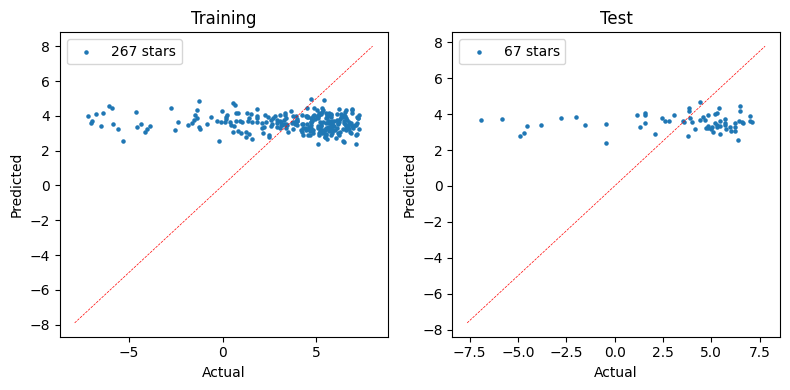

Train: 2.6175265412504793
Test: 2.607580846699464


In [17]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test

# Deep Bayesian Neural Network

In [18]:
class BNN_v3(PyroModule):
    def __init__(self, input_dim=5, output_dim=1, hid_dim=10, n_hid_layers=3, prior_scale=1.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU or Tanh
        assert input_dim > 0 and output_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [input_dim] + n_hid_layers * [hid_dim] + [output_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [19]:
# define model and data
model = BNN_v3(input_dim=5, output_dim=1, hid_dim=5, n_hid_layers=1, prior_scale=.5)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train_, y_train_)

Sample: 100%|██████████| 100/100 [04:00,  2.40s/it, step size=6.79e-03, acc. prob=0.885]


(267,) (67,)


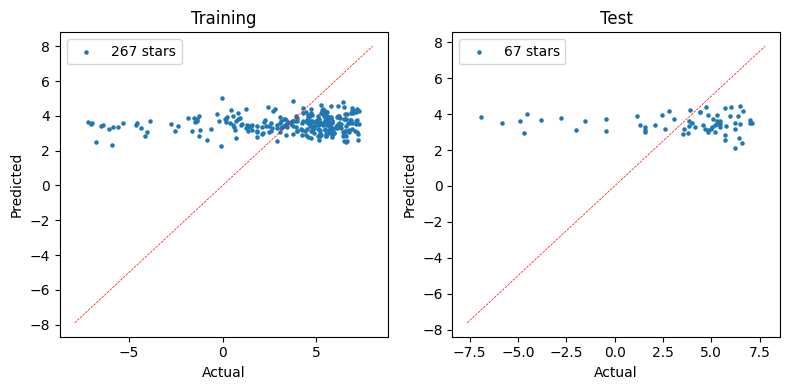

Train: 2.548285092410387
Test: 2.6498651479950492


In [20]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

print(prediction_train.shape, prediction_test.shape)


fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test

In [ ]:
# class MyFirstBNN(PyroModule):
#     def __init__(self, in_dim=5, out_dim=1, hid_dim=5, prior_scale=5.):
#         super().__init__()

#         self.activation = nn.LeakyReLU()  # nn.Tanh()  # or nn.ReLU() nn.LeakyReLU() 
#         self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
#         self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim) # hidden to hidden layer
#         self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim) # Hidden to output layer

#         # Set layer parameters as random variables
#         self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
#         self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

#         self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
#         self.layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))

#         self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
#         self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

#     def forward(self, x, y=None):
#         #x = x.reshape(-1, 1)
#         x = self.activation(self.layer1(x))
#         mu = self.layer2(x).squeeze()
#         sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

#         # Sampling model
#         with pyro.plate("data", x.shape[0]):
#             obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
#         return mu

# Train BNNs with mean-field variational inference

In [25]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train_, y_train_.squeeze())
    progress_bar.set_postfix(loss=f"{loss / x_train_.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [26]:
predictive = Predictive(model=model, guide=mean_field_guide, num_samples=500)
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape, prediction_test.shape

((261,), (112,))

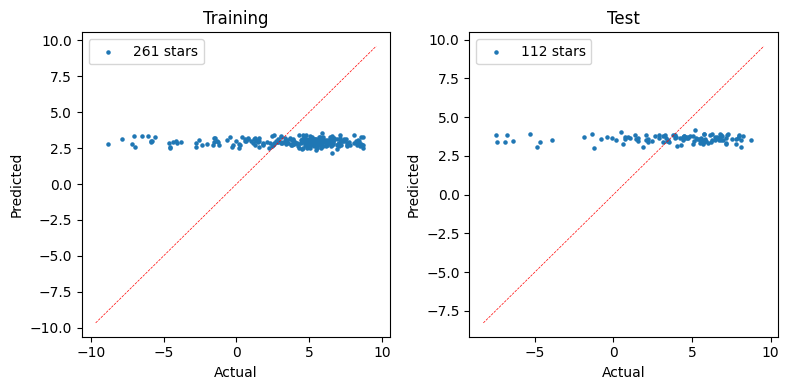

Train: 3.097637830152231
Test: 2.8741759913841465


In [27]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test